In [60]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import geodatasets
import numpy as np
import torch
import os

In [61]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["figure.dpi"] = 300
plt.rcParams["grid.linewidth"] = 1

In [62]:
train_data = pd.read_csv('train-conversion-answers.csv').set_index('ID')
test_data = pd.read_csv('test-conversion.csv').set_index('ID')
val_data = pd.read_csv('val-conversion-answers.csv').set_index('ID')
answers = pd.read_csv('answers.csv').set_index('ID')

In [63]:
BATCH_SIZE = 128
YEAR = 2005
samples_range = val_data[val_data['real_year'] == YEAR]
samples_range = samples_range[samples_range['lat'] < -25]
print(f"Batches for year {YEAR}: [{min(samples_range.index) // 128 - 1333} - {max(samples_range.index) // 128 + 1 - 1333}]")

Batches for year 2005: [290 - 329]


In [64]:
# for idx in tqdm(train_data.index, "Train processing"):
#     train_data.loc[idx, ['yield', 'class']] = answers.loc[idx, :]
# train_data.to_csv("train-conversion-answers.csv")
# for idx in tqdm(val_data.index, "Valifdation processing"):
#     val_data.loc[idx, ['yield', 'class']] = answers.loc[idx, :]
# val_data.to_csv("val-conversion-answers.csv") 

In [65]:
gdf = gpd.GeoDataFrame(train_data, geometry=gpd.points_from_xy(train_data['lon'], train_data['lat']), crs="EPSG:4326")

In [66]:
world = gpd.read_file(geodatasets.get_path("naturalearth land"))

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\g'
C:\Users\mekor\AppData\Local\Temp\ipykernel_15956\1649800877.py:9: SyntaxWarning: invalid escape sequence '\l'
  '$\leq$ 1.5', '[1.5 - 2.5)', '[2.5 - 3.5)',
C:\Users\mekor\AppData\Local\Temp\ipykernel_15956\1649800877.py:11: SyntaxWarning: invalid escape sequence '\g'
  '$\geq$ 6.5'])})


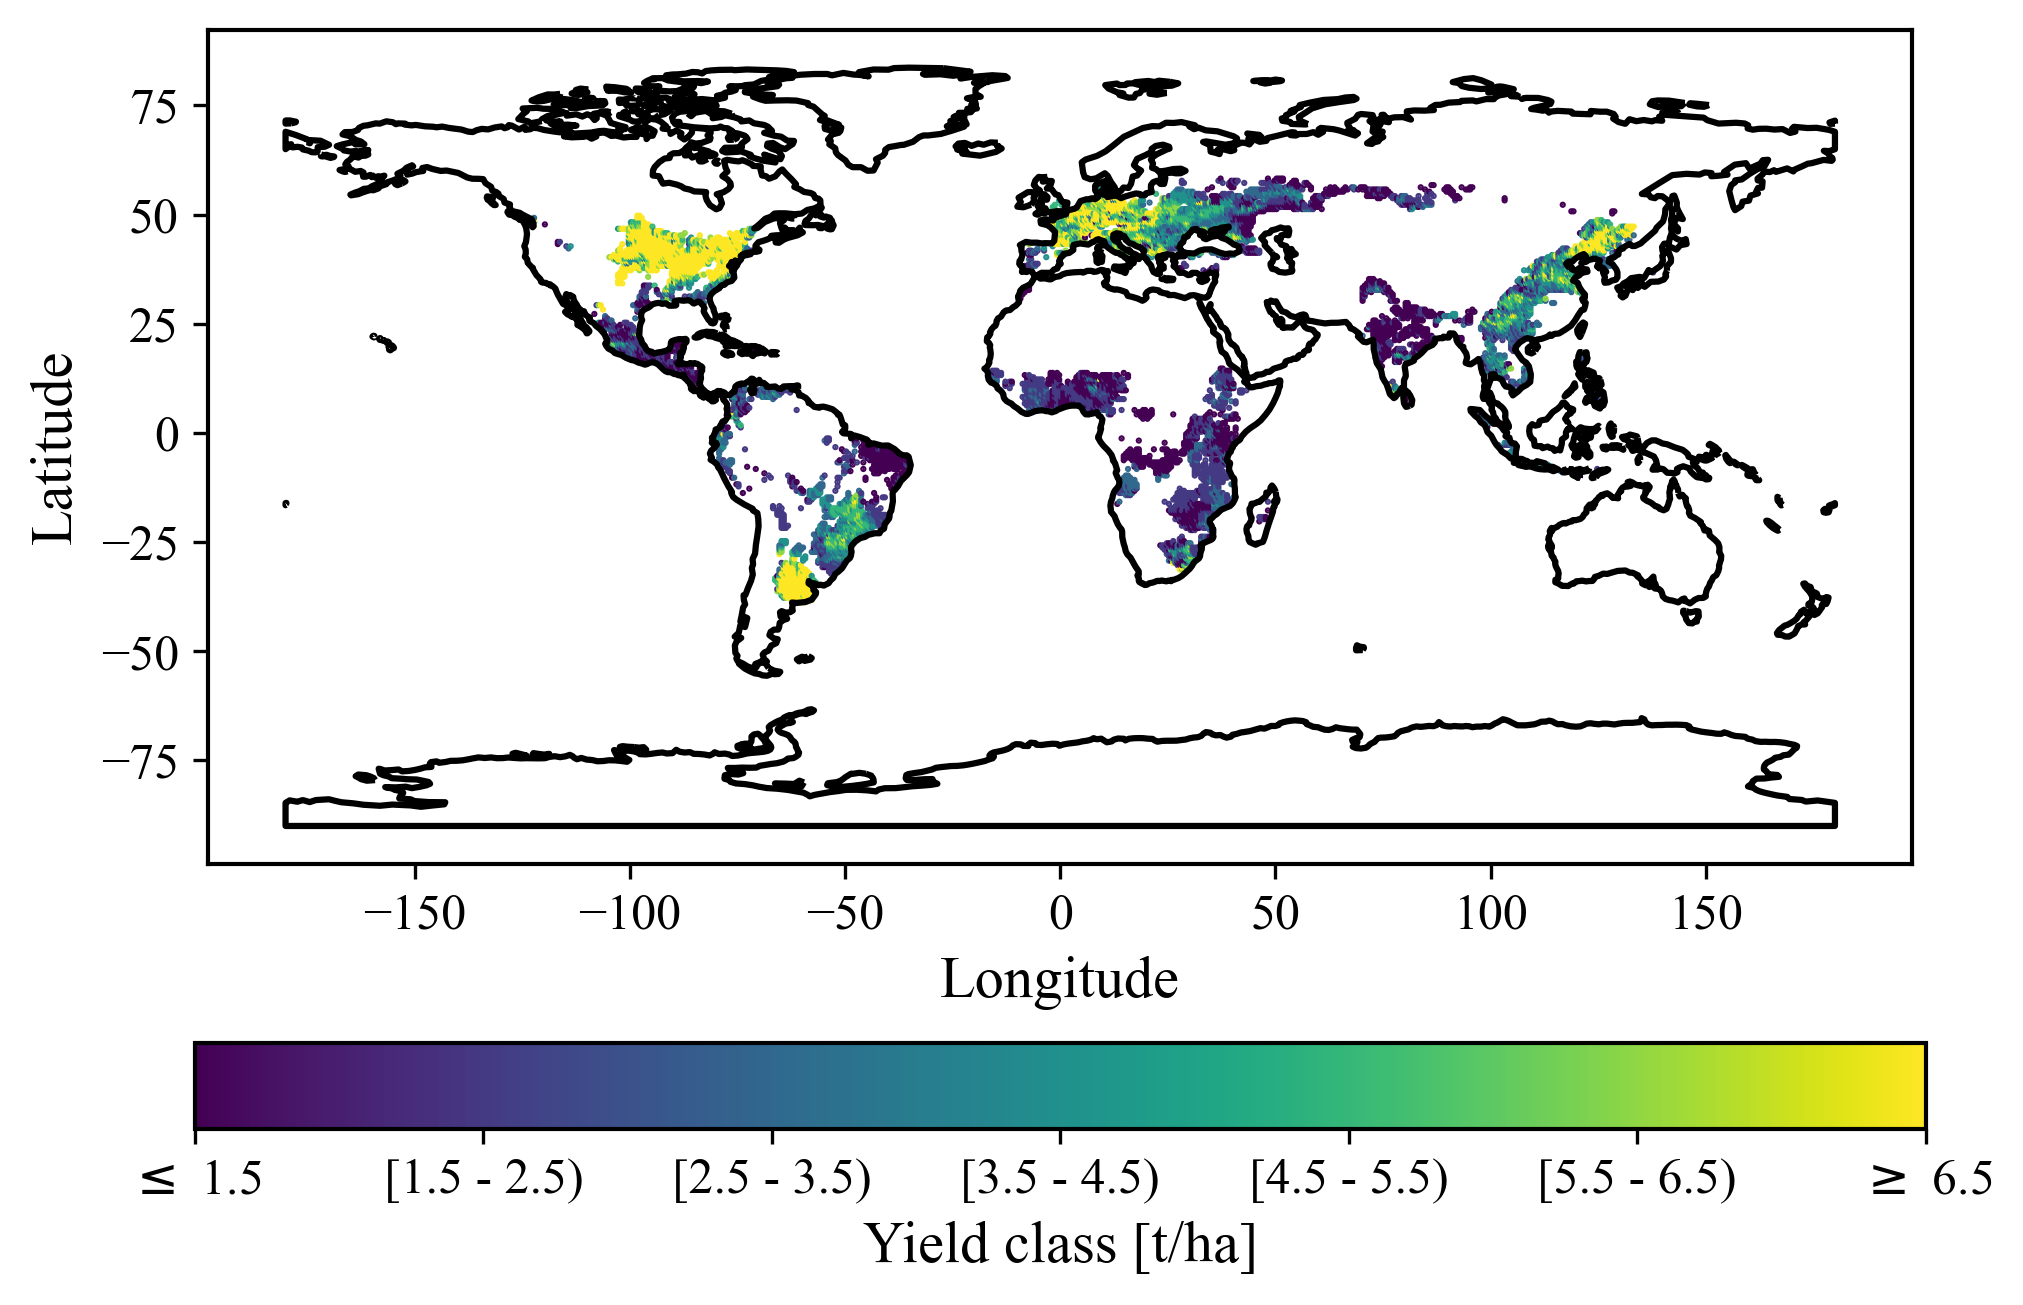

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6.75, 4.5))
world.boundary.plot(color='k', ax=ax)
gdf[gdf['real_year'] == 1990].plot(column='class', ax=ax, legend=True, markersize=0.25, 
                                   legend_kwds={
                                       'orientation' : 'horizontal',
                                       'label' : 'Yield class [t/ha]', 
                                       'ticks' : [1, 2, 3, 4, 5, 6, 7], 
                                       'format' : mticker.FixedFormatter([
                                           '$\leq$ 1.5', '[1.5 - 2.5)', '[2.5 - 3.5)', 
                                           '[3.5 - 4.5)', '[4.5 - 5.5)', '[5.5 - 6.5)', 
                                           '$\geq$ 6.5'])})
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
fig.savefig("FutureCrop-example.pdf", dpi=600)

In [68]:
FOLDER = './Output'
BATCH_SIZE = 128
def file2batch(input : str):
    return int(input[input.find('_')+1:input.find('.')])
files = sorted(os.listdir(FOLDER))

In [69]:
indexes = test_data.index
for file in files:
    batch = file2batch(file)
    pred = torch.load(os.path.join(FOLDER, file), 
                      map_location=torch.device('cpu'), 
                      weights_only=False)
    idx_range = indexes[BATCH_SIZE*batch:BATCH_SIZE*(batch+1)]
    test_data.loc[idx_range, 'pred'] = pred.detach().numpy() + 1

map_data = test_data.dropna()

In [70]:
prd = gpd.GeoDataFrame(map_data, geometry=gpd.points_from_xy(map_data['lon'], map_data['lat']), crs="EPSG:4326")

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\g'
C:\Users\mekor\AppData\Local\Temp\ipykernel_15956\2746227670.py:9: SyntaxWarning: invalid escape sequence '\l'
  '$\leq$ 1.5', '[1.5 - 2.5)', '[2.5 - 3.5)',
C:\Users\mekor\AppData\Local\Temp\ipykernel_15956\2746227670.py:11: SyntaxWarning: invalid escape sequence '\g'
  '$\geq$ 6.5'])})


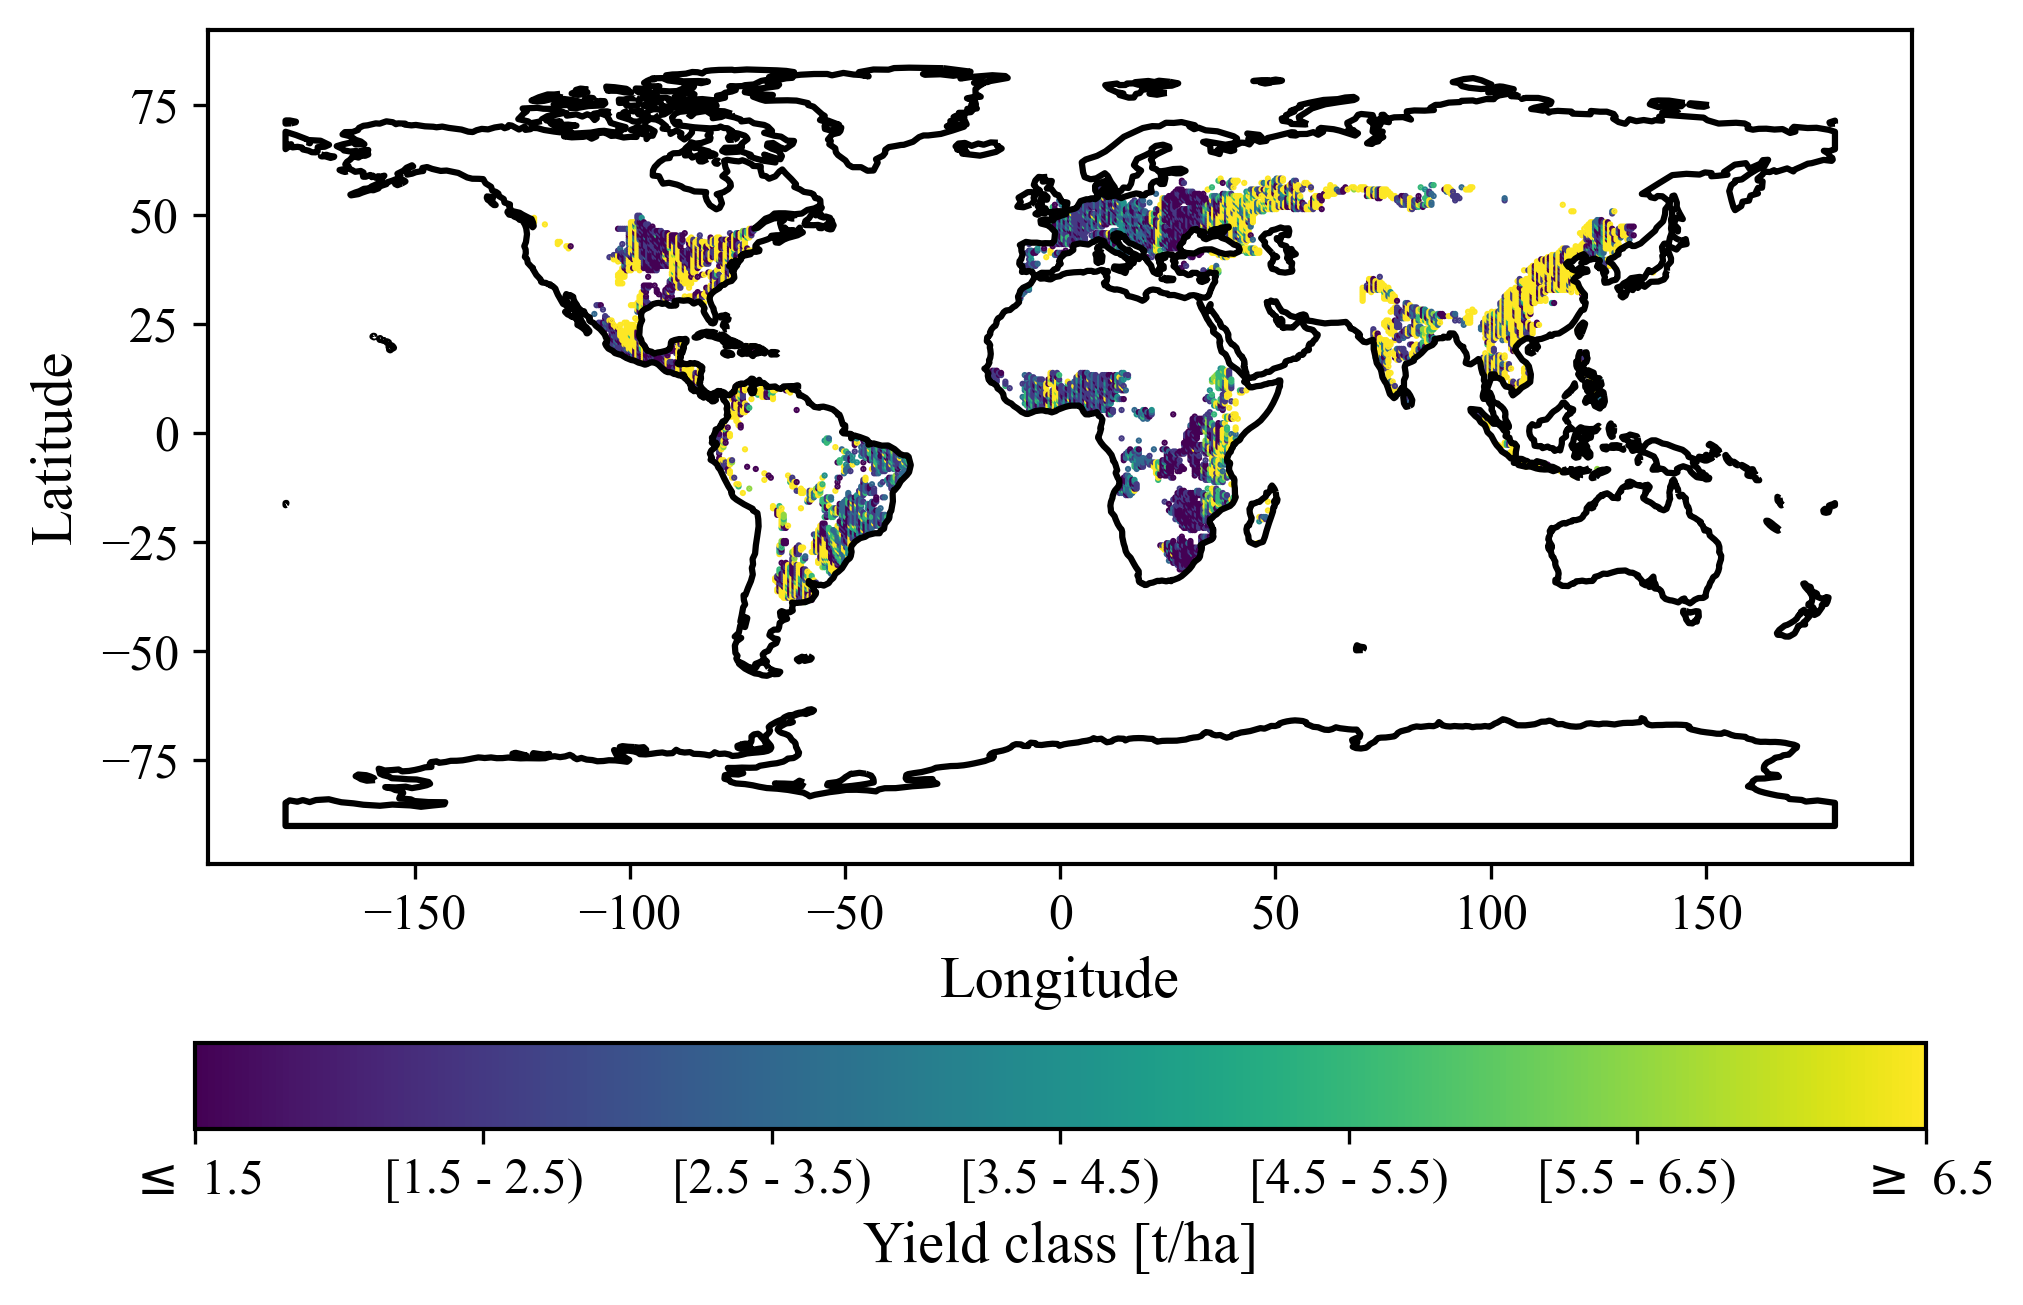

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6.75, 4.5))
world.boundary.plot(color='k', ax=ax)
prd[prd['real_year'] == 2021].plot(column='pred', ax=ax, legend=True, markersize=0.25,
                                   legend_kwds={
                                       'orientation' : 'horizontal',
                                       'label' : 'Yield class [t/ha]', 
                                       'ticks' : [1, 2, 3, 4, 5, 6, 7], 
                                       'format' : mticker.FixedFormatter([
                                           '$\leq$ 1.5', '[1.5 - 2.5)', '[2.5 - 3.5)', 
                                           '[3.5 - 4.5)', '[4.5 - 5.5)', '[5.5 - 6.5)', 
                                           '$\geq$ 6.5'])})
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
fig.savefig("FutureCrop-prediction.pdf", dpi=600)